## how often to genes in clusters share funciton?

inspired by https://www.nature.com/articles/s41467-021-25129-x, "The molecular basis, genetic control and pleiotropic effects of local gene co-expression", espeically figure 3 and go term enrishment analysis and https://www.nature.com/articles/s42003-022-03831-w "Shared regulation and functional relevance of local gene co-expression revealed by single cell analysis" go term enrichment analysis

* distance in groups vs not X
* paralog frequency
* bidirecitonal promotors X
* shared enhancers X 
* shared go term X
* same pathway
* same complex 
* inverted/total ctcf motifs between
* hi-c contacts? (from abc data?)

I want to make some plots here, and also add all of these annotations to the cluster file. At a later point, perhaps automate the annotation of the clusters file with this information

In [112]:
import numpy as np
import pandas as pd
import scipy as sp
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as stats
import math
import upsetplot as up



# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/tami_clusters/proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
my_tissue_id = 'Cells_Cultured_fibroblasts'

protien_coding_only = True

## load in data
cluster df, expression df, gencode

In [117]:
# load in cluster data for a single tissue
cluster_df = pd.read_csv(f'{prefix}/{clusters_dir}/{my_tissue_id}_clusters_all_chr.csv', index_col=0)

# load in cluster data for all tissues
all_tissue_cluster_dfs={}
for tissue_id in tissue_ids: 
    all_tissue_cluster_dfs[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv', index_col=0)

In [118]:
# load in expression data (so we only compare to pairs of genes also expressed in this tissue)
# load in gene expression data
expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{my_tissue_id}.v8.normalized_expression.bed', sep='\t')

# load in expression data for all tissues 
all_tissue_expression_dfs={}
for tissue_id in tissue_ids: 
    all_tissue_expression_dfs[tissue_id] = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')


In [119]:
# load in gene data
full_gencode=pd.read_csv(f'{prefix}/data/references/processed_gencode.v26.GRCh38.genes.csv')


# filter to protien coding
if protien_coding_only:
    non_protein_gencode = full_gencode.copy()
    full_gencode = full_gencode[full_gencode['gene_type'] == 'protein_coding']

gid_gencode = full_gencode.set_index('transcript_id').drop_duplicates()

# subset to ones expressed (commenting this as im moving to analyzing clusters in all tissues)
expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]

# index based on gene id
#expressed_gencode = expressed_gencode.set_index('transcript_id').drop_duplicates().sort_values(['chr', 'start', 'end'])

In [120]:
# expressed genes in each tissue
all_tissue_expressed_gencode_dfs={}
for tissue_id in tissue_ids: 
    expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(all_tissue_expression_dfs[tissue_id]['gene_id'])]
    expressed_gencode = expressed_gencode.sort_values(['chr', 'start', 'end'])
    all_tissue_expressed_gencode_dfs[tissue_id] = expressed_gencode


In [121]:
# load in ABC data for enhancer gene connections
full_abc_pred_df = pd.read_csv(f'{prefix}/data/references/functional_annotations/ABC_predictions/AllPredictions.AvgHiC.ABC0.015.minus150.ForABCPaperV3.txt.gz', sep='\t')

# load in tissue matching for ABC-gtex tissues
# this has to be done by hand
# some were clear, for those that aren't I've asked for help and put None for now

abc_gtex_match = pd.read_csv(f'{prefix}/data/references/functional_annotations/ABC_predictions/ABC_matched_gtex.csv')

# get just the enhancer-gene connections for the matched tissue
abc_df = full_abc_pred_df[full_abc_pred_df['CellType'] == abc_gtex_match[abc_gtex_match['GTEX_tissue'] == my_tissue_id]['ABC_biosample_id'].iloc[0]]

# add transcript ids to relevant abc enhancer-gene connection columns these and set as index
gene_enhancer_df = pd.merge(full_gencode[['transcript_id', 'gene_name']], abc_df[['TargetGene','name','class']], left_on='gene_name', right_on='TargetGene', how='left')
gene_enhancer_df.rename(columns={'name':'enhancer'}, inplace=True)
gene_enhancer_df.set_index('transcript_id', inplace=True)

In [122]:
# load in paralogues
#pd.read_csv(f'{prefix}/data/references/paralogues_biomart_ensembl.98.tsv.gz', sep='\t')

## nulls for each tissue, at each cluster size

maybe subsample these to make them smaller? 

Should they be genome wide, or all the ones not in the actual clusters?

In [123]:
# add cluster size from gene-gene into cluster df
def get_cluster_size(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    return  cluster_gencode['end'].max() - cluster_gencode['start'].min()

def get_cluster_tss_size(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    return  cluster_gencode['tss_start'].max() - cluster_gencode['tss_start'].min()

def get_cluster_start_ids(cluster_df):
    # the first for pairs, the first and second for threes, ect
    cluster_start_ids = []
    for i in range(cluster_df['N_genes'].max()):
        out_ids = cluster_df[cluster_df['N_genes'] == i]['Transcripts'].str.split(',').str[:i-1].values
        if len(out_ids)>0:
            cluster_start_ids.append(np.concatenate(out_ids))
        else:
            cluster_start_ids.append([])
    return cluster_start_ids

def annotate_sizes(cluster_df):
    cluster_df['cluster_size'] = cluster_df.progress_apply(get_cluster_size, axis=1)
    cluster_df['cluster_tss_size'] = cluster_df.progress_apply(get_cluster_tss_size, axis=1)

In [124]:
def get_null_clusters(expressed_gencode, cluster_size, cluster_df=None):
    # sort
    expressed_gencode = expressed_gencode.sort_values(['chr', 'start', 'end'])
    # on a per chrom basis
    null_cluster_dfs = []
    for chr_id in range (1,23,1):
        chr_subset_gencode = expressed_gencode[expressed_gencode['chr'] == f'chr{chr_id}']
        transcripts = chr_subset_gencode['transcript_id'].astype(str) + ',' + chr_subset_gencode['transcript_id'].shift(-(cluster_size-1)).astype(str)
        chr_sizes = chr_subset_gencode['end'].shift(-(cluster_size-1)) - chr_subset_gencode['start']

        # trim off the blanks created from shifting
        transcripts = transcripts.iloc[:-(cluster_size-1)]
        chr_sizes = chr_sizes.iloc[:-(cluster_size-1)]

        # select those that are not already clusters
        try:
            cluster_start_ids = get_cluster_start_ids(cluster_df)
            this_cluster_size_start_ids = np.concatenate(cluster_start_ids[cluster_size:])
            in_cluster_bool = pd.Series(chr_subset_gencode['transcript_id'].iloc[:-(cluster_size-1)]).isin(this_cluster_size_start_ids).values
            null_cluster_dfs.append(pd.DataFrame({'Transcripts':transcripts[~in_cluster_bool], 'cluster_size':chr_sizes[~in_cluster_bool], 'chr':chr_id}))
        except TypeError:
            # no subselection wanted, i.e.None passed for cluster_df
            null_cluster_dfs.append(pd.DataFrame({'Transcripts':transcripts, 'cluster_size':chr_sizes, 'chr':chr_id}))

    null_df = pd.concat(null_cluster_dfs)
    null_df.reset_index(drop=True, inplace=True)
    return null_df
    

In [125]:
# code from ben
# target has to be smaller or the two, n is length of target

def resample_dist(target, candidate_pool, n, seed=126124):   
    """Match a target distribution via weighted sampling from a candidate pool
    Args:
        target, candidate_pool: 1D numpy arrays with values ranging from 0 to 1
        n: integer number of indices to return
    Return:
        n indices to elements candidate_pool to use for the sample
    """
    rng = np.random.default_rng(seed)
    target_prob = sp.stats.gaussian_kde(target)
    candidate_prob = sp.stats.gaussian_kde(candidate_pool)

    bins = np.arange(0, 1, 0.0001)
    sampling_weight = target_prob(bins) / candidate_prob(bins)
    pool_bins = np.searchsorted(bins, candidate_pool) - 1
    pool_probability = sampling_weight[pool_bins]/sampling_weight[pool_bins].sum()

    return rng.choice(candidate_pool.size, size=n, replace=True, p=pool_probability)


def get_resamp_null_cluster(null_df, cluster_df, plot=False, number_null = 1000):
    # note that cluster_df should be resticted only to clusters with a matching number of transcripts already

    join_df = pd.concat([cluster_df, null_df], keys=['cluster', 'null'], names=['is_cluster', 'id'])
    if plot:
        # size distribution before
        sns.kdeplot(join_df, x='size', hue='is_cluster', bw_adjust=.3, common_norm=False, log_scale=(10,None))
        plt.title('Distance distribution before resampling')
        plt.show()

    # add a normalized cluster size column to resample on
    cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_size'])/np.log10(join_df['cluster_size'].max())
    null_df['normed_log_size'] = np.log10(null_df['cluster_size'])/np.log10(join_df['cluster_size'].max())

    # resample to match distance
    resamp_idxs = resample_dist(cluster_df['normed_log_size'], null_df['normed_log_size'], n=number_null)
    resamp_null_df = null_df.reset_index().iloc[resamp_idxs]

    if plot:
        # size distribution after resampling
        join_df = pd.concat([cluster_df, resamp_null_df], keys=['cluster', 'null'], names=['is_cluster', 'id'])
        sns.kdeplot(join_df, x='size', hue='is_cluster', bw_adjust=.3, common_norm=False, log_scale=(10,None))
        plt.title('Distance distribution after resampling')
        plt.show()

    return resamp_null_df
        

In [127]:
null_pairs_genome = get_null_clusters(expressed_gencode, 2, cluster_df=None)
annotate_sizes(cluster_df)
null_pairs_genome_dist_matched = get_resamp_null_cluster(null_pairs_genome, cluster_df[cluster_df['N_genes']==2])

null_pairs_exclude_clusters = get_null_clusters(expressed_gencode, 2, cluster_df=cluster_df)

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.43332694/ipykernel_5809/1056232570.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_size'])/np.log10(join_df['cluster_size'].max())


## other annotation functions

#### bidirectional promotors
if two of the genes in the cluster are opposite strand with tss < 1000 bp away, classify as bidirecitonal promotor

#### Enhancer sharing 
* Supp data 4 from "Shared regulation and functional relevance of local gene co-expression revealed by single cell analysis" (https://www.nature.com/articles/s42003-022-03831-w#data-availability) correlated atac and rna-seq acessibility for epi map regions in LCLs, showed high concordence with ABC and epi map? (this could only work for lcl type cells, which I don't really have)

* ABC for 131 biosmaples (could probably find matches for most of mine) from Nasser et al. Nature (2021): Genome-wide enhancer maps connect risk variants to disease genes. (download link: https://www.engreitzlab.org/resources) copied from /oak/stanford/groups/engreitz/public/Nasser2021

#### GO term sharing, paralogs

downloaded all go terms for ensemble IDs from biomart

what is a BP go term?

In [128]:
def get_bidirectional(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    # check all pairwise combos of genes
    for idx, first_gene_row in cluster_gencode.iterrows():
        for idx, second_gene_row in cluster_gencode.iterrows():
            opp_strand = first_gene_row['strand'] != second_gene_row['strand']
            close = abs(first_gene_row['tss_start'] - second_gene_row['tss_start']) <= 1000
            if opp_strand & close:
                # found a bidirectional promotor
                return True
    # didn't find a bidirectional promotor
    return False

def annotate_bidirectional(cluster_df):
    cluster_df['bidirectional_promoter'] = cluster_df.progress_apply(get_bidirectional, axis=1)


In [129]:
# annotate clusters with the number of shared enhancers

def annotate_enhancers(cluster_df, gene_enhancer_df):
    for idx, row in tqdm(cluster_df.iterrows(), total=len(cluster_df)):
        enhancer_list = gene_enhancer_df.loc[row['Transcripts'].split(',')]['enhancer']
        enhancer_list = enhancer_list[~enhancer_list.isna()]
        num_shared_enhancers = sum(enhancer_list.duplicated())
        cluster_df.loc[idx, 'num_shared_enhancers'] = num_shared_enhancers
        cluster_df.loc[idx, 'num_enhancers'] = len(enhancer_list)
        cluster_df.loc[idx, 'shared_enhancers'] = str(enhancer_list[enhancer_list.duplicated()].unique())
        cluster_df.loc[idx, 'enhancers'] = str(enhancer_list.unique())
        cluster_df.loc[idx, 'has_shared_enhancer'] = num_shared_enhancers > 0

### annotate a cluster df

In [130]:
annotate_sizes(cluster_df)
annotate_bidirectional(cluster_df)
annotate_enhancers(cluster_df, gene_enhancer_df)

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [131]:
annotate_bidirectional(null_pairs_exclude_clusters)

  0%|          | 0/13078 [00:00<?, ?it/s]

## plotting functions

#### upset/overlap between categories

In [152]:

def plot_upset_binary_categories(cluster_df, column_list):
    upset_cluster_df = cluster_df.set_index(column_list[0])
    for column_name in column_list[1:]:
        upset_cluster_df.set_index(column_name, append=True, inplace=True)

    fig = plt.figure(figsize=(8, 5))
    upset = up.UpSet(upset_cluster_df)
    upset.plot(fig=fig)


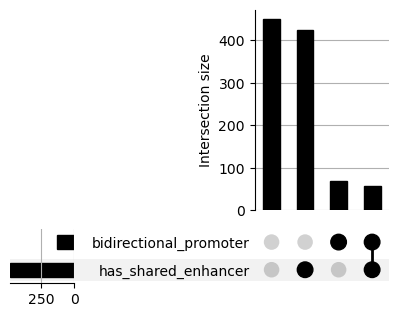

In [153]:
plot_upset_binary_categories(cluster_df, ['bidirectional_promoter', 'has_shared_enhancer'])

### log odds

In [154]:
# plot odds ratios

def get_odds_ratio(contingency_table):
    # One-sided Fisher's exact test
    odds_ratio, p_value = stats.fisher_exact(contingency_table, alternative='greater')
    print("Odds Ratio:", odds_ratio)
    print("P-value:", p_value)

    # Compute 95% confidence interval for odds ratio
    a, b, c, d = contingency_table.flatten()
    SE = np.sqrt(1/a + 1/b + 1/c + 1/d)
    lcb = math.exp(math.log(odds_ratio) - 1.96*SE)  # lower confidence bound
    ucb = math.exp(math.log(odds_ratio) + 1.96*SE)  # upper confidence bound
    print(f"CI: [{lcb}, {ucb}]")

    return p_value, odds_ratio, lcb, ucb

def get_contingency_table(cluster_df, null_df, column_name):
    num_cluster = sum(cluster_df[column_name])
    num_null = sum(null_df[column_name])
    # Build contingency table
    # [[yes clusters, no clusters] [yes null, no null]]
    contingency_table = np.array([[num_cluster, len(cluster_df)-num_cluster],[num_null, len(null_df)-num_null]])
    return contingency_table

In [155]:
get_contingency_table(cluster_df, null_pairs_exclude_clusters, 'bidirectional_promoter')

array([[  126,   873],
       [  882, 12196]])

In [156]:
p_value, odds_ratio, lcb, ucb = get_odds_ratio(get_contingency_table(cluster_df, null_pairs_exclude_clusters, 'bidirectional_promoter'))
 pd.Series({'p_value': pvalue ,
            'odds_ratio':odds_ratio,
            'lower_cb':lcb,
            'upper_cb':ucb,
            'col'})


Odds Ratio: 1.9957453771886762
P-value: 1.3043041870498572e-10
CI: [1.6357819036830543, 2.434920940011639]


(1.3043041870498572e-10,
 1.9957453771886762,
 1.6357819036830543,
 2.434920940011639)

## Cluster Sizes
pairs on genes in clusters vs random pairs
and for larger groups vs other random larger groups

In [22]:
# get the size distribution and tissue specific null for each tissue
null_size_dfs = []
for tissue_id in tissue_ids: 
    # add cluster size to the cluster df
    all_tissue_cluster_dfs[tissue_id]['cluster_size'] = all_tissue_cluster_dfs[tissue_id].apply(get_cluster_size, axis=1)
    # add a label column to the cluster df 
    all_tissue_cluster_dfs[tissue_id]['data_type'] = all_tissue_cluster_dfs[tissue_id]['N_genes'].clip(0,4).astype(str) + '_cluster'
    # get a null df
    null_df = pd.concat([get_null_clusters(all_tissue_expressed_gencode_dfs[tissue_id], i, cluster_df) for i in range(2, 5, 1)], 
                        keys=['2_null', '3_null', '4_null'], 
                        names=['data_type', 'idx']).reset_index(level='data_type')
    null_size_dfs.append(null_df)

TypeError: '<=' not supported between instances of 'str' and 'int'

In [ ]:
null_df = pd.concat(null_size_dfs, keys=tissue_ids, names=['tissue_id', 'idx'])

In [ ]:
# combine the clusters and null
size_plot_df = pd.concat([pd.concat(all_tissue_cluster_dfs), pd.concat(null_size_dfs)])
size_plot_df['log_cluster_gene_size'] = np.log10(size_plot_df['cluster_size'])

# add label columns
size_plot_df['is_cluster'] = size_plot_df['data_type'].str.contains('cluster')
size_plot_df['N_genes'] = size_plot_df['data_type'].str.split('_').str[0].astype(int)

# add tss-tss size
size_plot_df['cluster_tss_size'] = size_plot_df.progress_apply(get_cluster_tss_size, axis=1)
size_plot_df['log_cluster_tss_size'] = np.log10(size_plot_df['cluster_tss_size'])

size_plot_df.reset_index(drop=True, inplace=True)


  0%|          | 0/598695 [00:00<?, ?it/s]

In [ ]:
# fixing an error
size_plot_df['cluster_size_gene'] = np.where(size_plot_df['size'].isna(), size_plot_df['cluster_size'], size_plot_df['size'])
size_plot_df['log_cluster_gene_size'] = np.log10(size_plot_df['cluster_size_gene'])


Text(0.5, 0, 'Number genes in cluster')

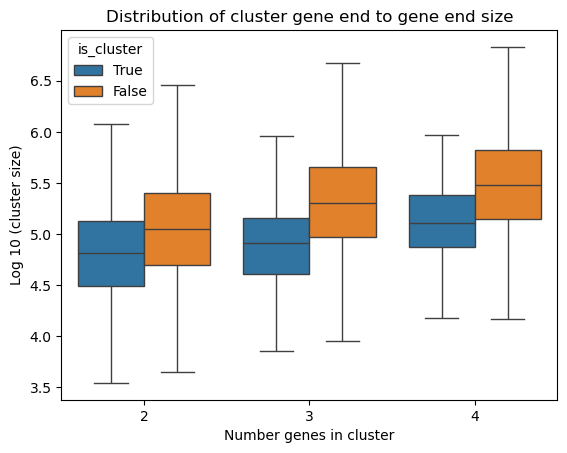

In [ ]:
sns.boxplot(size_plot_df, y='log_cluster_gene_size', x='N_genes', hue='is_cluster', hue_order=[True, False], showfliers=False)
plt.title('Distribution of cluster gene end to gene end size')
plt.ylabel('Log 10 (cluster size)')
plt.xlabel('Number genes in cluster')

Text(0.5, 0, 'Number genes in cluster')

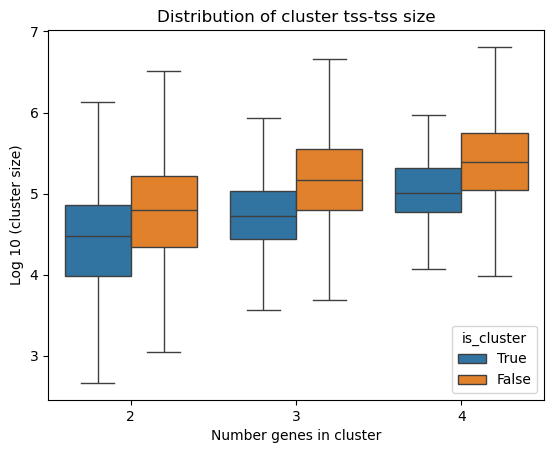

In [ ]:
sns.boxplot(size_plot_df, y='log_cluster_tss_size', x='N_genes', hue='is_cluster', hue_order=[True, False], showfliers=False)
plt.title('Distribution of cluster tss-tss size')
plt.ylabel('Log 10 (cluster size)')
plt.xlabel('Number genes in cluster')

In [ ]:

# subsample size_plot_df to match number of nulls to number of clusters of each size
subsampled_null=[]
for i in range(2,5,1):
    num_samples = sum(size_plot_df['data_type'] == f'{i}_cluster') *10
    subsampled_null.append(size_plot_df[size_plot_df['data_type'] == f'{i}_null'].sample(num_samples))

# combine into one df
sub_null_size_plot_df = pd.concat([pd.concat(cluster_size_dfs), pd.concat(subsampled_null)])
# add label column
sub_null_size_plot_df['is_cluster'] = sub_null_size_plot_df['data_type'].str.contains('cluster')


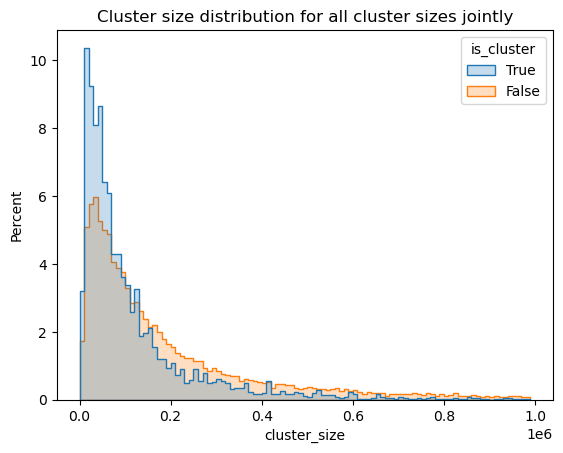

In [ ]:
sns.histplot(sub_null_size_plot_df, x='cluster_size', hue='is_cluster', bins=np.arange(0, 10**6,10**4), 
             common_norm=False, stat='percent', element='step', hue_order=[True, False])

plt.title('Cluster size distribution for all cluster sizes jointly')
plt.show()

In [43]:
# create one df with all tissues clusters
all_tissue_cluster_df = pd.concat(all_tissue_cluster_dfs, keys=tissue_ids)
# get bidirectional info for the clusters
all_tissue_cluster_df['bi_promotor'] = all_tissue_cluster_df.progress_apply(get_bidirectional, axis=1)

In [49]:
# get genome-wide null counts for each tissues expressed genes
all_tissues_bidirectional_nulls = []

for tissue_id in tissue_ids:
    expression_df = all_tissue_expression_dfs[tissue_id]
    # subset to ones expressed (commenting this as im moving to analyzing clusters in all tissues)
    expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]
    # index based on gene id
    expressed_gencode = expressed_gencode.set_index('transcript_id').drop_duplicates().sort_values(['chr', 'start', 'end'])

    bidirectional_nulls={2:[], 3:[], 4:[]}

    gencode_df = expressed_gencode.sort_values(['chr', 'start', 'end'])
    for chr_id in range (1,23,1):
        chr_subset_gencode = gencode_df[gencode_df['chr'] == f'chr{21}']

        # the two conditions that must be met
        opp_strand = chr_subset_gencode['strand'] != chr_subset_gencode['strand'].shift(-1)
        close = abs(chr_subset_gencode['tss_start'] - chr_subset_gencode['tss_start'].shift(-1)) <= 1000

        # combine and extend conditions for larger clusters
        bidirectional_nulls[2] = np.concatenate([bidirectional_nulls[2], opp_strand & close])
        
    bidirectional_nulls[2] = pd.Series(bidirectional_nulls[2], dtype=bool)
    bidirectional_nulls[3] = bidirectional_nulls[2] | bidirectional_nulls[2].shift(-1)
    bidirectional_nulls[4] = bidirectional_nulls[2] | bidirectional_nulls[2].shift(-1) | bidirectional_nulls[2].shift(-2)

    all_tissues_bidirectional_nulls.append(pd.DataFrame(bidirectional_nulls))

all_tissues_bidirectional_nulls = pd.concat(all_tissues_bidirectional_nulls)


In [51]:
# get the relative fractions of bidirectional promotors or not
all_tissue_cluster_df['N_genes_clip'] = all_tissue_cluster_df['N_genes'].clip(1,4)

frac_df = {}
frac_df_noise={}
for num_genes in range(2,5):
    sub_cluster = all_tissue_cluster_df[all_tissue_cluster_df['N_genes_clip']==num_genes]
    frac_df[f'cluster_{num_genes}'] = sum(sub_cluster['bi_promotor']/len(sub_cluster))
    frac_df_noise[f'cluster_{num_genes}'] = np.sqrt(len(sub_cluster))/len(sub_cluster)

    frac_df[f'null_{num_genes}'] = sum(all_tissues_bidirectional_nulls[num_genes])/len(all_tissues_bidirectional_nulls[num_genes])
    # assume enough samples for no noise in null
    frac_df_noise[f'null_{num_genes}'] = 0

frac_bi_df = pd.DataFrame({'fraction':frac_df, 'noise':frac_df_noise})
frac_bi_df['num_genes'] = [2,2,3,3,4,4]
frac_bi_df['null_ind'] = [False,True]*3

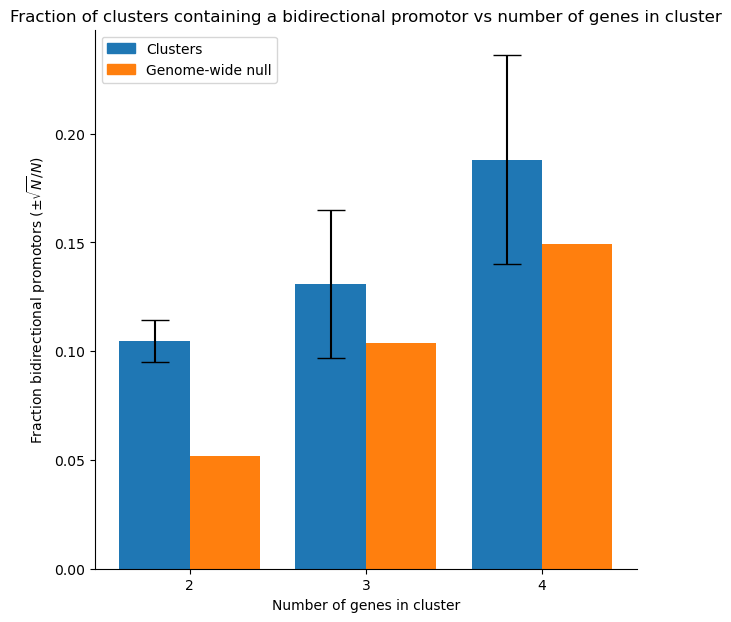

In [52]:
# plot fractions of bidirectional promotors
fig, ax = plt.subplots(figsize=(7,7))

width=.4

# for the clusters
sub_frac_df = frac_bi_df[(frac_bi_df['null_ind']==False)]
ax.bar(height=sub_frac_df['fraction'], x=sub_frac_df['num_genes'], width=width, color=sns.color_palette()[0])
ax.errorbar(y=sub_frac_df['fraction'], x=sub_frac_df['num_genes'], yerr=sub_frac_df['noise'],  ls='none', color='k', capsize=10)

# for the null
sub_frac_df = frac_bi_df[(frac_bi_df['null_ind']==True)]
ax.bar(height=sub_frac_df['fraction'], x=sub_frac_df['num_genes']+width, width=width, color=sns.color_palette()[1])

# axis and labels
ax.set_xticks(sub_frac_df['num_genes'] + width / 2, ('2', '3', '4'))
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Number of genes in cluster')
ax.set_ylabel('Fraction bidirectional promotors ($\pm \sqrt{N}/N$)')
ax.set_title('Fraction of clusters containing a bidirectional promotor vs number of genes in cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend
cluster_patch = mpatches.Patch(color=sns.color_palette()[0], label='Clusters')
null_patch = mpatches.Patch(color=sns.color_palette()[1], label='Genome-wide null')
plt.legend(handles=[cluster_patch, null_patch])

## paralog frequency
how often are both genes paralogs/a nearby gene duplication?
is this something I can tell wtih go terms?

In [134]:
# annotate clusters with the number of shared enhancers

def annotate_enhancers(cluster_df):
    for idx, row in tqdm(cluster_df.iterrows(), total=len(cluster_df)):
        enhancer_list = gene_enhancer_df.loc[row['Transcripts'].split(',')]['enhancer']
        enhancer_list = enhancer_list[~enhancer_list.isna()]
        num_shared_enhancers = sum(enhancer_list.duplicated())
        cluster_df.loc[idx, 'num_shared_enhancers'] = num_shared_enhancers
        cluster_df.loc[idx, 'num_enhancers'] = len(enhancer_list)
        cluster_df.loc[idx, 'shared_enhancers'] = str(enhancer_list[enhancer_list.duplicated()].unique())
        cluster_df.loc[idx, 'enhancers'] = str(enhancer_list.unique())


annotate_enhancers(cluster_df)

  0%|          | 0/1138 [00:00<?, ?it/s]

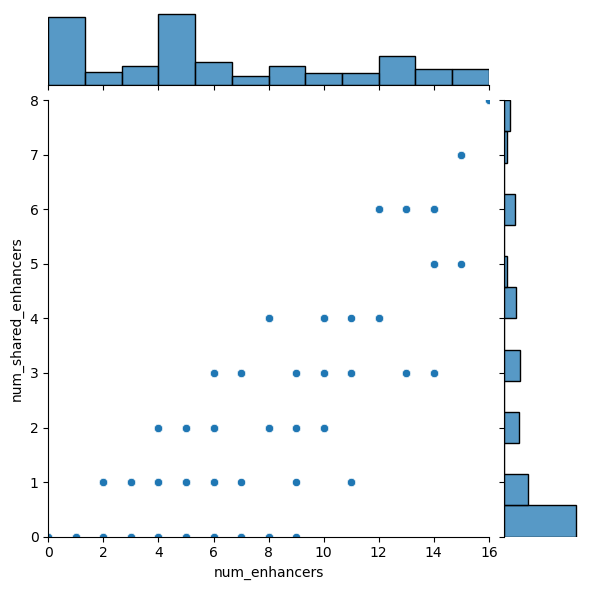

In [135]:
sns.jointplot(cluster_df, y='num_shared_enhancers', x='num_enhancers', xlim=(0, cluster_df['num_enhancers'].max()), ylim=(0,cluster_df['num_shared_enhancers'].max()))

In [136]:
# how many pairs share an enhancer?

# subset to expressed genes for the null
expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]

pairs_null_df = get_null_clusters(expressed_gencode, 2, None)
annotate_enhancers(pairs_null_df)

sum(pairs_null_df['num_shared_enhancers']>0)/len(pairs_null_df)

  0%|          | 0/14068 [00:00<?, ?it/s]

0.5275092408302531

Text(0.5, 0, 'Number of shared enhancers')

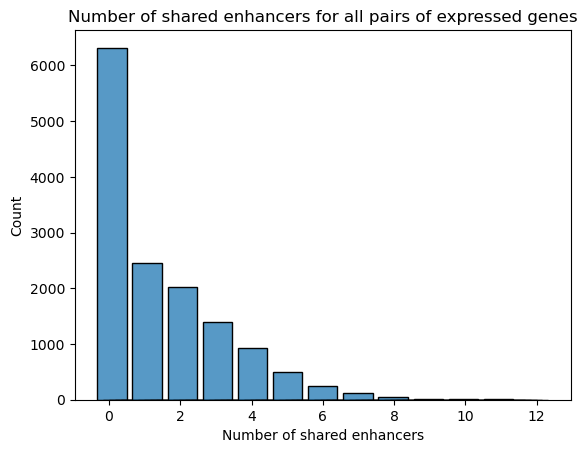

In [106]:
sns.histplot(pairs_null_df['num_shared_enhancers'], shrink=5)
plt.title('Number of shared enhancers for all pairs of expressed genes')
plt.xlabel('Number of shared enhancers')

In [137]:
# code from ben
# target has to be smaller or the two, n is length of target

def resample_dist(target, candidate_pool, n, seed=126124):   
    """Match a target distribution via weighted sampling from a candidate pool
    Args:
        target, candidate_pool: 1D numpy arrays with values ranging from 0 to 1
        n: integer number of indices to return
    Return:
        n indices to elements candidate_pool to use for the sample
    """
    rng = np.random.default_rng(seed)
    target_prob = sp.stats.gaussian_kde(target)
    candidate_prob = sp.stats.gaussian_kde(candidate_pool)

    bins = np.arange(0, 1, 0.0001)
    sampling_weight = target_prob(bins) / candidate_prob(bins)
    pool_bins = np.searchsorted(bins, candidate_pool) - 1
    pool_probability = sampling_weight[pool_bins]/sampling_weight[pool_bins].sum()

    return rng.choice(candidate_pool.size, size=n, replace=True, p=pool_probability)

In [143]:
def get_resamp_null_cluster(cluster_df, gencode_df, num_genes, plot=False, number_null = 1000):
    # add size to the cluster
    cluster_df['size'] = cluster_df.apply(get_cluster_size, axis=1)
    # get a pairs null df
    full_null_df = get_null_clusters(gencode_df, num_genes, cluster_df)

    join_df = pd.concat([cluster_df[cluster_df['N_genes']==num_genes], full_null_df], keys=['cluster', 'null'], names=['is_cluster', 'id'])
    if plot:
        # size distribution before
        sns.kdeplot(join_df, x='size', hue='is_cluster', bw_adjust=.3, common_norm=False, log_scale=(10,None))
        plt.title(f'Distance distribution before resampling (num_genes  = {num_genes})')
        plt.show()

    # add a normalized cluster size column to resample on
    cluster_df['normed_log_size'] = np.log10(cluster_df['size'])/np.log10(join_df['size'].max())
    full_null_df['normed_log_size'] = np.log10(full_null_df['size'])/np.log10(join_df['size'].max())

    # resample to match distance
    resamp_idxs = resample_dist(cluster_df[cluster_df['N_genes']==num_genes]['normed_log_size'], full_null_df['normed_log_size'], n=number_null)
    resamp_null_df = full_null_df.reset_index().iloc[resamp_idxs]

    if plot:
        # size distribution after resampling
        join_df = pd.concat([cluster_df[cluster_df['N_genes']==num_genes], resamp_null_df], keys=['cluster', 'null'], names=['is_cluster', 'id'])
        sns.kdeplot(join_df, x='size', hue='is_cluster', bw_adjust=.3, common_norm=False, log_scale=(10,None))
        plt.title(f'Distance distribution after resampling (num_genes  = {num_genes})')
        plt.show()

    return resamp_null_df
        

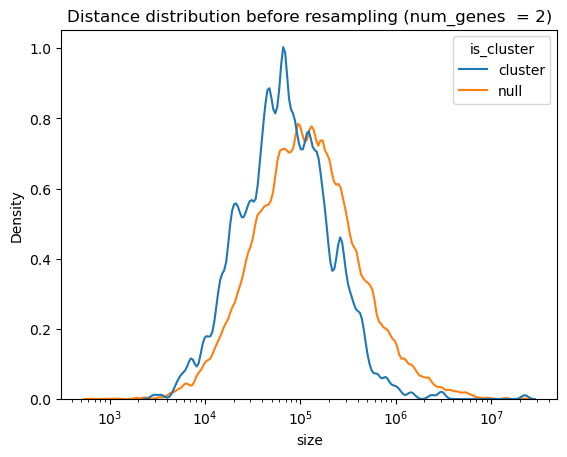

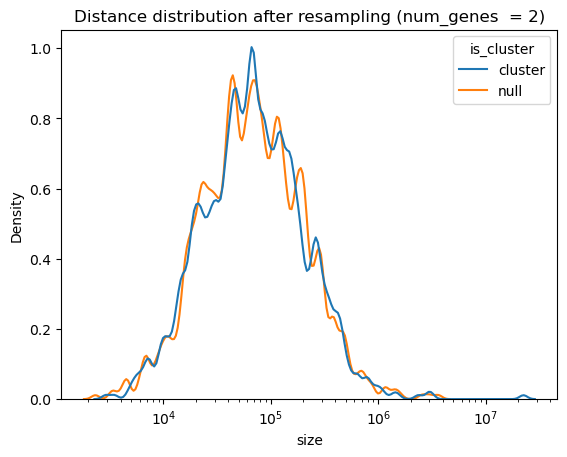

In [144]:
resamp_null_2_df = get_resamp_null_cluster(cluster_df, expressed_gencode, 2, plot=True)

#### distribution in number of shared enhancers
There is no difference in the fraction of shared enhancers. Most pairs of genes have a shared enhancer in fact. I think many of these are one gene's promotor acting as another nearby gene's enhancer. Maybe there will be a differnece in the number of shared enhancers?

In [145]:

# get null distirbutions and number of enhancers for each
resamp_null_dfs = []
for num_genes in range(2,5):
    resamp_null = (get_resamp_null_cluster(cluster_df, expressed_gencode, num_genes))
    annotate_enhancers(resamp_null)
    resamp_null_dfs.append(resamp_null)

# make into one df
resamp_null_dfs = pd.concat(resamp_null_dfs, keys=['2_null','3_null','4_null'], names=['data_type', 'idx'])

  0%|          | 0/1000 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.43144458/ipykernel_29173/2510309917.py:17: RuntimeWarning: divide by zero encountered in divide
  sampling_weight = target_prob(bins) / candidate_prob(bins)


  0%|          | 0/1000 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.43144458/ipykernel_29173/2510309917.py:17: RuntimeWarning: divide by zero encountered in divide
  sampling_weight = target_prob(bins) / candidate_prob(bins)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [146]:
# make into one df
join_df = pd.concat([resamp_null_dfs.reset_index(), cluster_df], keys=['null', 'cluster'], names=['is_cluster', 'idx'])
join_df.reset_index('is_cluster', inplace=True)
join_df['N_genes'] = join_df['data_type'].str.split('_').str[0].astype(int)

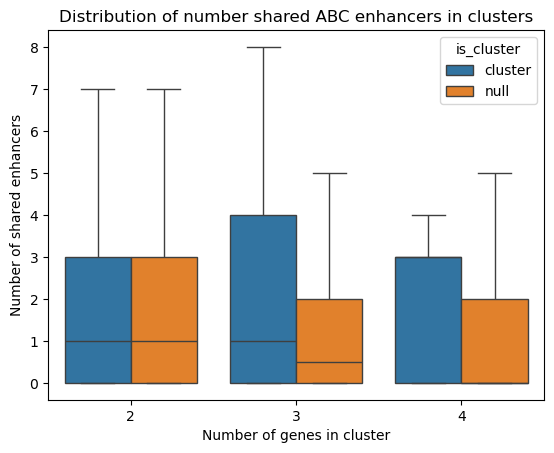

In [147]:
join_df['N_genes'] = join_df['N_genes'].clip(0,4)
# plot boxplot of shared enhancers
sns.boxplot(join_df, y='num_shared_enhancers', hue='is_cluster', x='N_genes', hue_order=['cluster', 'null'], showfliers=False)
plt.ylabel('Number of shared enhancers')
plt.xlabel('Number of genes in cluster')
plt.title('Distribution of number shared ABC enhancers in clusters')
plt.show()

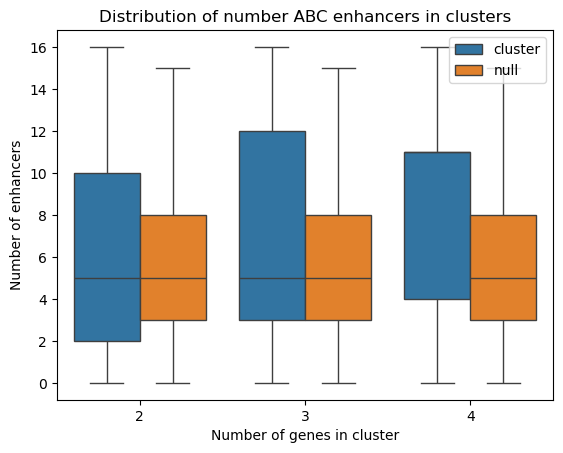

In [148]:
# plot boxplot of shared enhancers
sns.boxplot(join_df, y='num_enhancers', hue='is_cluster', x='N_genes', hue_order=['cluster', 'null'], showfliers=False)
plt.ylabel('Number of enhancers')
plt.xlabel('Number of genes in cluster')
plt.title('Distribution of number ABC enhancers in clusters')
plt.legend(loc='upper right')
plt.show()

## GO term sharing

downloaded all go terms for ensemble IDs from https://www.ensembl.org/biomart/martview/5132e4b3722dbd1e4a1ea25bdeff2a24

GrCH38.p14 genes

In [106]:
# load in go term df

go_term_df_path = '/home/klawren/oak/pcqtls/data/references/goterm_annotations.mart_export.txt'

# set index as the stable id without version, as the versions differ between this dataset and the dataset used for cluster transcript ids
go_df = pd.read_csv(go_term_df_path, sep='\t')
go_df.head()

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene name,GO term accession,GO term name,GO term evidence code,GO domain,GO term definition
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,MT-TF,GO:0030533,triplet codon-amino acid adaptor activity,IEA,molecular_function,The codon binding activity of a tRNA that posi...
1,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,MT-TF,GO:0006412,translation,IEA,biological_process,The cellular metabolic process in which a prot...
2,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,MT-RNR1,NaN,NaN,NaN,NaN,NaN
3,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,MT-TV,NaN,NaN,NaN,NaN,NaN
4,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,MT-RNR2,GO:0003735,structural constituent of ribosome,IEA,molecular_function,The action of a molecule that contributes to t...


In [142]:
# get a table linking transcript ids to list of unique go terms for that transcript

def unique_non_null(s):
    return s.dropna().unique()

transcript_id_go_df = go_df.groupby('Gene stable ID').agg({'GO term accession':unique_non_null})

# and linking gene names to unique go terms
gene_name_go_df = go_df.groupby('Gene name').agg({'GO term accession':unique_non_null})

In [153]:
# function to get a list of all go terms for the transcripts in the cluster
def get_go_terms(row):
    cluster_ts = row['Transcripts'].split(',')
    cluster_ts = [t.split('.')[0] for t in cluster_ts]
    try:
        go_terms = transcript_id_go_df.loc[cluster_ts]['GO term accession']

    except KeyError:
        # some gene ids don't match, try with gene names instead
        gene_names = gid_gencode.loc[row['Transcripts'].split(',')]['gene_name']
        try:
            go_terms = gene_name_go_df.loc[gene_names]['GO term accession']
        except KeyError:
            # some have changed names between versions
            print('skipped {}'.format(gene_names))
            return []
    return go_terms.values

# function to take in df with above annotated and return the number of shared go terms
def count_shared_go(row):
    # flatten the go terms into one list
    flat_go = pd.Series([go_term for go_term_list in row['go_terms'] for go_term in go_term_list])
    # number of unique shared go terms
    return flat_go[flat_go.duplicated()].nunique()

In [154]:
# get the go terms for each transcript
cluster_df['go_terms'] = cluster_df.progress_apply(get_go_terms, axis=1)

# count the number of shared go terms for each transcript
cluster_df['nshared_go_terms'] = cluster_df.progress_apply(count_shared_go, axis=1)

  0%|          | 0/861 [00:00<?, ?it/s]

skipped transcript_id
ENSG00000284413.1        BTBD8
ENSG00000069712.12    KIAA1107
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000203818.7    HIST2H3PS2
ENSG00000263513.5        FAM72C
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000113916.17            BCL6
ENSG00000223401.2     RP11-211G3.2
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000163945.15     UVSSA
ENSG00000179979.8     CRIPAK
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000186354.10    C9orf47
ENSG00000213694.3       S1PR3
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000165895.17    ARHGAP42
ENSG00000170647.3      TMEM133
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000150526.12      MIA2
ENSG00000150527.16    CTAGE5
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000155307.17        SAMSN1
ENSG00000243440.6     AF165138.7
Name: gene_name, dtype: object


  0%|          | 0/861 [00:00<?, ?it/s]

In [162]:
# get a null of pairs
pairs_null_df = get_null_clusters(all_tissue_expressed_gencode_dfs[tissue_id], 2, cluster_df)

# get the go terms for each transcript
pairs_null_df['go_terms'] = pairs_null_df.progress_apply(get_go_terms, axis=1)

# count the number of shared go terms for each transcript
pairs_null_df['nshared_go_terms'] = pairs_null_df.progress_apply(count_shared_go, axis=1)

  0%|          | 0/13235 [00:00<?, ?it/s]

skipped transcript_id
ENSG00000069712.12    KIAA1107
ENSG00000174842.16        GLMN
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000270882.2      HIST2H4A
ENSG00000203812.2    HIST2H2AA3
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000203812.2    HIST2H2AA3
ENSG00000272196.2    HIST2H2AA4
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000272196.2     HIST2H2AA4
ENSG00000184678.10     HIST2H2BE
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000157181.15    C1orf27
ENSG00000262180.1        OCLM
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000262180.1      OCLM
ENSG00000073756.11    PTGS2
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000178694.9        NSUN3
ENSG00000269028.3    MTRNR2L12
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000269028.3    MTRNR2L12
ENSG00000113966.9         ARL6
Name: gene_name, dtype: object
skipped transcript_id
ENSG00000114656.10        KIAA1257
ENSG00000187695.8     R

  0%|          | 0/13235 [00:00<?, ?it/s]

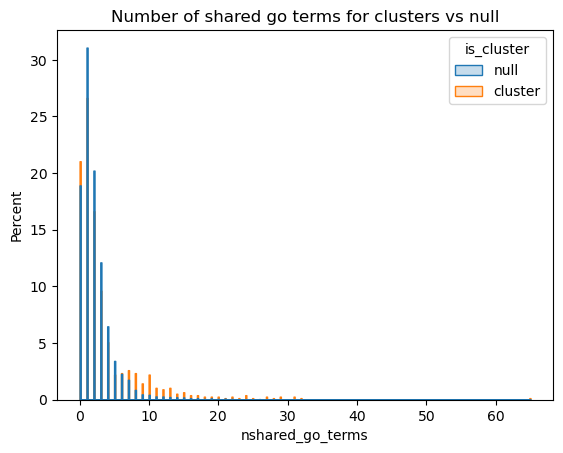

In [168]:
# compare just the pairs against each other

# make into one df
join_df = pd.concat([pairs_null_df.reset_index(), cluster_df[cluster_df['N_genes']==2]], keys=['null', 'cluster'], names=['is_cluster', 'idx'])
join_df.reset_index('is_cluster', inplace=True)

sns.histplot(join_df, x='nshared_go_terms', hue='is_cluster', 
            common_norm=False, stat='percent', element='step')

plt.title('Number of shared go terms for clusters vs null')
plt.show()

In [171]:
join_df['shared_go_bool'] = join_df['nshared_go_terms'] > 0
def get_frac_shared(sub_df):
    return sum(sub_df['shared_go_bool'])/len(sub_df)
print('Fraction shared: \n\tcluster {}\n\tnull {}'.format(get_frac_shared(join_df[join_df['is_cluster']=='cluster']), get_frac_shared(join_df[join_df['is_cluster']=='null'])))

Fraction shared: 
	cluster 0.7896103896103897
	null 0.8109557990177559
